# Case 3. Patient Drug Review
**Neural Networks for Machine Learning Applications**<br>
12.03.2023<br>
Erik Holopainen, Alejandro Rosales Rodriguez and Brian van den Berg<br>
[Information Technology, Bachelor's Degree](https://www.metropolia.fi/en/academics/bachelors-degrees/information-technology)<br>
[Metropolia University of Applied Sciences](https://www.metropolia.fi/en)

## 1. Introduction

Instructions: Write here why this Notebook was created, what were the main objectives.

## 2. Setup

Instructions: Write here shortly what libraries were used and why.

In [398]:
# Machine Learning and Data Science
import pandas as pd
import numpy as np
import nltk
from textblob import TextBlob

# Modeling neural networks
import tensorflow as tf
from keras.models import Sequential
from keras.layers import Dense, Embedding, LSTM, Conv1D, MaxPooling1D, Dropout, Bidirectional
from keras.preprocessing.text import Tokenizer
from keras.utils import to_categorical
from keras.utils import pad_sequences

# Sklearn
import sklearn
from sklearn.model_selection import train_test_split

# Data Visualization
import matplotlib
import matplotlib.pyplot as plt

# General imports
import html
import re
import sys
import os

# Print the library versions
print('\033[1m' + 'Notebook Version Register:' + '\033[0m')
print(f'[Python {sys.version}]')
print(f'[{tf.__name__} {tf.__version__}]')
print(f'[{pd.__name__} {pd.__version__}]')
print(f'[{np.__name__} {np.__version__}]')
print(f'[{nltk.__name__} {nltk.__version__}]')
print(f'[{sklearn.__name__} {sklearn.__version__}]')
print(f'[{matplotlib.__name__} {matplotlib.__version__}]')

Notebook Version Register:
[Python 3.10.9 (tags/v3.10.9:1dd9be6, Dec  6 2022, 20:01:21) [MSC v.1934 64 bit (AMD64)]]
[tensorflow 2.11.0]
[pandas 1.5.3]
[numpy 1.24.1]
[nltk 3.8.1]
[sklearn 1.2.0]
[matplotlib 3.6.3]


### Download

By using the function 'nltk.download('popular')' we are checking if the python environment already has access to the nltk datasets. If the datasets are already there, it marks the requirement as satisfied and if the datasets are outdated or if they're not even there, then nltk downloads the resources for you.

In [399]:
# Fetch the nltk datasets
nltk.download('popular')

[nltk_data] Downloading collection 'popular'
[nltk_data]    | 
[nltk_data]    | Downloading package cmudict to
[nltk_data]    |     C:\Users\brian\AppData\Roaming\nltk_data...
[nltk_data]    |   Package cmudict is already up-to-date!
[nltk_data]    | Downloading package gazetteers to
[nltk_data]    |     C:\Users\brian\AppData\Roaming\nltk_data...
[nltk_data]    |   Package gazetteers is already up-to-date!
[nltk_data]    | Downloading package genesis to
[nltk_data]    |     C:\Users\brian\AppData\Roaming\nltk_data...
[nltk_data]    |   Package genesis is already up-to-date!
[nltk_data]    | Downloading package gutenberg to
[nltk_data]    |     C:\Users\brian\AppData\Roaming\nltk_data...
[nltk_data]    |   Package gutenberg is already up-to-date!
[nltk_data]    | Downloading package inaugural to
[nltk_data]    |     C:\Users\brian\AppData\Roaming\nltk_data...
[nltk_data]    |   Package inaugural is already up-to-date!
[nltk_data]    | Downloading package movie_reviews to
[nltk_data]   

True

## 3. Dataset

In [400]:
# Load in the dataframe
df = pd.read_csv('input\\drugsComTrain_raw.csv')

# Display the dataframe
display(df)

# Display the dataframe description
print("Description of the dataframe:")
display(df.describe().T)

,uniqueID,drugName,condition,review,rating,date,usefulCount
0,206461,Valsartan,Left Ventricular Dysfunction,"""It has no side effect, I take it in combinati...",9,20-May-12,27
1,95260,Guanfacine,ADHD,"""My son is halfway through his fourth week of ...",8,27-Apr-10,192
2,92703,Lybrel,Birth Control,"""I used to take another oral contraceptive, wh...",5,14-Dec-09,17
3,138000,Ortho Evra,Birth Control,"""This is my first time using any form of birth...",8,3-Nov-15,10
4,35696,Buprenorphine / naloxone,Opiate Dependence,"""Suboxone has completely turned my life around...",9,27-Nov-16,37
...,...,...,...,...,...,...,...
161292,191035,Campral,Alcohol Dependence,"""I wrote my first report in Mid-October of 201...",10,31-May-15,125
161293,127085,Metoclopramide,Nausea/Vomiting,"""I was given this in IV before surgey. I immed...",1,1-Nov-11,34
161294,187382,Orencia,Rheumatoid Arthritis,"""Limited improvement after 4 months, developed...",2,15-Mar-14,35
161295,47128,Thyroid desiccated,Underactive Thyroid,"""I&#039;ve been on thyroid medication 49 years...",10,19-Sep-15,79


Description of the dataframe:


,count,mean,std,min,25%,50%,75%,max
uniqueID,161297.0,115923.585305,67004.445170,2.0,58063.0,115744.0,173776.0,232291.0
rating,161297.0,6.994377,3.272329,1.0,5.0,8.0,10.0,10.0
usefulCount,161297.0,28.004755,36.403742,0.0,6.0,16.0,36.0,1291.0


### Prepare

In [401]:
# Change all columns to lowercase
df = df.applymap(lambda x: x.lower() if type(x) == str else x)

# Drop duplicate rows from the data
df.drop_duplicates(subset='review', inplace=True)

# Decode HTML-encoded words
df['review'] = df['review'].apply(html.unescape)

# Drop all rows with NaN review and 1 character reviews
df.dropna(subset=['review'], inplace=True)
df = df[df['review'].str.strip().astype(bool)]
df = df[df['review'].str.len() > 1]

# Remove hashtags from reviews <-- neutral (didn't change much)
def remove_hashtags(text):
    return re.sub(r'#\w+', '', text)
df['review'] = df['review'].apply(remove_hashtags)

# Display the current state of our dataframe
display(df)

,uniqueID,drugName,condition,review,rating,date,usefulCount
0,206461,valsartan,left ventricular dysfunction,"""it has no side effect, i take it in combinati...",9,20-may-12,27
1,95260,guanfacine,adhd,"""my son is halfway through his fourth week of ...",8,27-apr-10,192
2,92703,lybrel,birth control,"""i used to take another oral contraceptive, wh...",5,14-dec-09,17
3,138000,ortho evra,birth control,"""this is my first time using any form of birth...",8,3-nov-15,10
4,35696,buprenorphine / naloxone,opiate dependence,"""suboxone has completely turned my life around...",9,27-nov-16,37
...,...,...,...,...,...,...,...
161289,105263,carbamazepine,trigeminal neuralgia,"""up to 800mg seems to work about once every 2n...",1,31-jan-16,10
161290,103458,tekturna,high blood pressure,"""i have only been on tekturna for 9 days. the ...",7,7-feb-10,18
161292,191035,campral,alcohol dependence,"""i wrote my first report in mid-october of 201...",10,31-may-15,125
161295,47128,thyroid desiccated,underactive thyroid,"""i've been on thyroid medication 49 years, i s...",10,19-sep-15,79


## 4. Preprocessing

Instructions: Describe:

- how the missing values are handled
- conversion of textual and categorical data into numerical values (if needed)
- how the data is splitted into train, validation and test sets
- the features (=input) and labels (=output), and 
- how the features are normalized or scaled

### Splitting Reviews and Labels

In [402]:
# Get the reviews
X_train = list(df['review'])
y_train = list(df['rating'])

### Filtering and Lemmatizing the Reviews

In [403]:
# Define the nltk variables
en_stopwords = nltk.corpus.stopwords.words('english')
lemmatizer = nltk.stem.WordNetLemmatizer()

# Function to preprocess text
def lemmatize_sentence(sentence):
    sentence = nltk.word_tokenize(sentence)
    
    # process all tokens aslong as they're alpha-numeric (text)
    result = []
    for token in sentence:
        if token not in en_stopwords and token.isalnum():
            token = lemmatizer.lemmatize(token)
            result.append(token)

    # Join the seperate strings back into a single string
    if len(result) > 0:
        sentence = result.pop(0)
        for word in result:
            sentence += ' ' + word
    else:
        sentence = ''

    return sentence

# Print the first sample before lemmatization
print('Before lemmatization:')
print(X_train[0])

# Lemmatize the training data
for i in range(len(X_train)):
    X_train[i] = lemmatize_sentence(X_train[i])

# Print the first sample after lemmatization
print('\nAfter lemmatization:')
print(X_train[0])

Before lemmatization:
"it has no side effect, i take it in combination of bystolic 5 mg and fish oil"

After lemmatization:
side effect take combination bystolic 5 mg fish oil


### Tokenizing the Reviews

In [404]:
# Maximum amount of words for the model to process
unique_words = set()
for review in X_train:
    unique_words.update(set(word for word in review.strip().split()))
num_words = round(len(unique_words) * .1)
print(f'Number of different unique words in tokenizer: {num_words}')

# Create a Tokenizer
tokenizer = Tokenizer(num_words=num_words)
tokenizer.fit_on_texts(X_train)

# Tokenize the reviews
X_train = tokenizer.texts_to_sequences(X_train)

Number of different unique words in tokenizer: 4468


### Padding the Reviews

In [405]:
# Get the biggest sequence in the data
maxlen = 0
for seq in X_train:
    if len(seq) > maxlen:
        maxlen = len(seq)
print(f'Maximum words in a review: {maxlen}')

# Pad the sequences
X_train = pad_sequences(X_train, maxlen=maxlen)

Maximum words in a review: 798


### Simplify the Labels

In [406]:
# Simplification function
def simplify(rating):
    if rating < 5:
        return 0
    elif rating <= 6:
        return 1
    else:
        return 2

# Simplify the labels
y_train = np.array(list(map(simplify, y_train)))

### Encode the Labels

In [407]:
# Calculate the class weights
total = len(y_train)
unique, counts = np.unique(y_train, return_counts=True)

# Encode the labels for multi classification
y_train = np.array(to_categorical(y_train))

# Print the distribution
print(f'The unique labels are: [{unique[0]}, {unique[1]}, {unique[2]}] with a distribution of [{counts[0]}, {counts[1]}, {counts[2]}].')

The unique labels are: [0, 1, 2] with a distribution of [27836, 9992, 74475].


### Preprocessing Pipelines

In [408]:
# Function to prepare a review for the model
def prepare_review(review):
    review = lemmatize_sentence(review)
    review = tokenizer.texts_to_sequences([review])
    return pad_sequences(review, maxlen=maxlen)[0]

# Function to prepare an array of arrays for training and testing
def prepare_reviews_arr(reviews):
    for i in range(len(reviews)):
        reviews[i] = prepare_review(reviews[i])
    return reviews

# Function to prepare a labels array for training and testing
def prepare_labels_arr(labels):
    labels = np.array(list(map(simplify, labels)))
    return np.array(to_categorical(labels))

## 5. Modeling

Instructions: Write a short description of the model: 

- selected loss, optimizer and metrics settings, and 
- the summary of the selected model architecture. 

In [409]:
# Create an LSTM model
model = Sequential([
    Embedding(num_words + 1, 100, input_length=maxlen),
    Conv1D(32, 7, activation='relu'),
    MaxPooling1D(5),
    LSTM(64, dropout=.1, recurrent_dropout=.1),
    Dense(64, activation='relu'),
    Dropout(.2),
    Dense(3, activation='softmax')
])

# Compile the model
model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['Accuracy', 'Recall'])

# Summarize the model
model.summary()

Model: "sequential_31"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_32 (Embedding)    (None, 798, 100)          446900    
                                                                 
 conv1d_34 (Conv1D)          (None, 792, 32)           22432     
                                                                 
 max_pooling1d_25 (MaxPoolin  (None, 158, 32)          0         
 g1D)                                                            
                                                                 
 lstm_23 (LSTM)              (None, 64)                24832     
                                                                 
 dense_54 (Dense)            (None, 64)                4160      
                                                                 
 dropout_15 (Dropout)        (None, 64)                0         
                                                     

## 6. Training

Instructions: Write a short description of the training process, and document the code for training and the total time spend on it. 

### Fitting

In [410]:
# Model Fitting
history = model.fit(
    X_train, y_train,
    batch_size=128,
    epochs=10,
    verbose=1,
    validation_split=.2
)

Epoch 1/10
617/702 [=========================>....] - ETA: 30s - loss: 0.6723 - Accuracy: 0.7391 - recall: 0.6895

KeyboardInterrupt: 

## 7. Performance and evaluation

Instructions: 

- Show the training and validation loss and accuracy plots
- Interpret the loss and accuracy plots (e.g. is there under- or over-fitting)
- Describe the final performance of the model with test set 

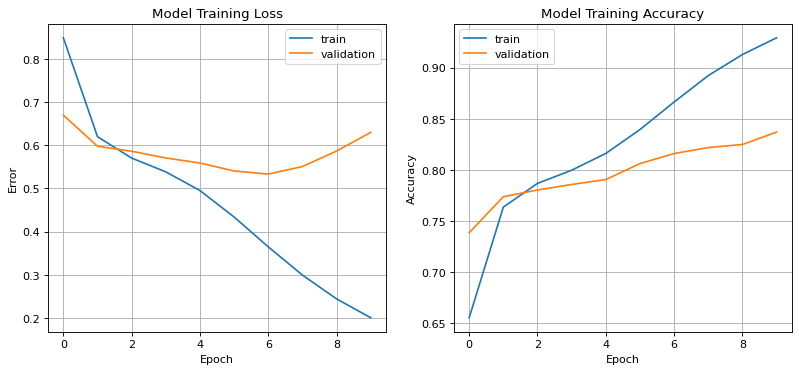

In [ ]:
# Define a function to plot the loss curve
def plotLoss(h, name):
    plt.plot(h.history['loss'], label='train')
    plt.plot(h.history['val_loss'], label='validation')
    plt.title('{0} Training Loss'.format(name))
    plt.xlabel('Epoch')
    plt.ylabel('Error')
    plt.legend()
    plt.grid(True)

# Plot the Accuracy curve
def plotAccuracy(h, name):
    plt.plot(h.history['Accuracy'], label='train')
    plt.plot(h.history['val_Accuracy'], label='validation')
    plt.title('{0} Training Accuracy'.format(name))
    plt.xlabel('Epoch')
    plt.ylabel('Accuracy')
    plt.legend()
    plt.grid(True)

# Define the sub-plot size
nCols = 2
nRows = 1

# Prepare the Loss Plots
plt.figure(figsize=(nCols * 6, nRows * 5), dpi=80)

# Plot the Loss
plt.subplot(nRows, nCols, 1)
plotLoss(history, 'Model')

# Plot the Accuracy
plt.subplot(nRows, nCols, 2)
plotAccuracy(history, 'Model')

# Draw the plots
plt.show()



## 8. Discussion and conclusions

Instructions: Write

- What settings and models were tested before the best model was found
    - What where the results of these experiments 
- Summary of  
    - What was your best model and its settings 
    - What was the final achieved performance 
- What are your main observations and learning points
- Discussion how the model could be improved in future 

**Note:** Remember to evaluate the final metrics using the test set. 
